In [1]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm, trange
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random
import logomaker

import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)
from source.alpha_beta_paired_clones_search import plot_cooccured_epitopes_table
from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble, \
                            plot_volcano, create_epitope_name
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column, prepare_clonotype_matrix
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence, \
                                    create_summary_stats_table, check_significant_epitopes_for_all_clusters, read_association_data
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')

/home/evlasova/tcr-covid-classifier


In [2]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [3]:
um_beta = pd.read_csv('data/standardized_usage_matrix_fmba_TRB_v.csv').drop(columns=['Unnamed: 0'])

In [4]:
um_alpha = pd.read_csv('data/standardized_usage_matrix_fmba_TRA_v.csv').drop(columns=['Unnamed: 0'])

In [5]:
um_alpha

,run,project,covid,TRAV25,TRAV22,TRAV8-6,TRAV12-1,TRAV23DV6,TRAV34,TRAV24,...,TRAV10,TRAV4,TRAV30,TRAV36DV7,TRAV9-2,TRAV8-7,TRAV38-1,TRAV8-2,TRAV16,is_test_run
0,050002290808_S117_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.034580,0.007386,0.035094,0.020193,0.034198,0.006992,0.014441,...,0.015582,0.008641,0.008739,0.015403,0.027845,9.388818e-08,0.013693,0.011404,0.018486,False
1,050002630808_S113_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.007756,0.010688,0.031960,0.045913,0.022326,0.006622,0.007731,...,0.014030,0.013210,0.005481,0.016437,0.039805,9.476407e-08,0.002049,0.011904,0.015449,False
2,050003120808_S112_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.031519,0.007588,0.008670,0.015329,0.000924,0.008048,0.019866,...,0.012097,0.020422,0.006971,0.016630,0.051908,1.015446e-07,0.016875,0.010910,0.017584,False
3,050003130808_S114_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.032442,0.014822,0.023636,0.025560,0.020243,0.006228,0.013844,...,0.018731,0.016480,0.006318,0.016605,0.057254,9.971174e-08,0.004958,0.010880,0.023764,False
4,050003450808_S118_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.029227,0.018550,0.017009,0.032554,0.036016,0.004463,0.015886,...,0.008191,0.013133,0.007600,0.015575,0.047376,9.439327e-08,0.019207,0.009621,0.023442,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,p18_72_DNA_S88_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.022219,0.019494,0.021428,0.049995,0.002439,0.005405,0.016207,...,0.011865,0.017337,0.005342,0.009265,0.070032,8.840376e-08,0.018956,0.013536,0.018417,False
1269,p18_73_DNA_S89_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.032089,0.019695,0.025329,0.049680,0.003760,0.004434,0.015811,...,0.011457,0.015376,0.005171,0.011067,0.051577,9.040503e-08,0.021368,0.003485,0.018169,False
1270,p18_74_DNA_S90_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.014704,0.024342,0.018804,0.023129,0.022389,0.007660,0.013431,...,0.026982,0.016394,0.006953,0.013791,0.029375,1.058087e-07,0.027750,0.005513,0.031534,False
1271,p18_75_DNA_S91_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.002557,0.017365,0.013523,0.057518,0.024586,0.003807,0.012010,...,0.035550,0.019303,0.005730,0.008685,0.025011,9.168310e-08,0.019486,0.013192,0.026893,False


In [6]:
train_runs_beta = prepare_run_column(um_beta[~um_beta.is_test_run]).run
test_runs_beta = prepare_run_column(um_beta[um_beta.is_test_run]).run

In [7]:
train_runs_alpha = prepare_run_column(um_alpha[~um_alpha.is_test_run]).run
test_runs_alpha = prepare_run_column(um_alpha[um_alpha.is_test_run]).run

In [8]:
desc_alpha = pd.read_csv('data/preprocessed_fmba_metadata_alpha.csv').drop(columns=['Unnamed: 0'])
desc_alpha['run'] = desc_alpha.R1.apply(lambda x: x.replace('_R1_001.fastq.gz', '.clonotypes.TRA.txt'))
desc_alpha = desc_alpha.merge(um_alpha[['run', 'is_test_run']])
desc_alpha['covid'] = desc_alpha.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc_alpha

,sequencingDate,folder,R1,R2,name,COVID_status,projectName,COVID_IgG,COVID_IgM,COVID_PCR,...,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,run,is_test_run,covid
0,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002290808_S117_L002_R1_001.fastq.gz,050002290808_S117_L002_R2_001.fastq.gz,050002290808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002290,NaN,NaN,NaN,NaN,NaN,050002290808_S117_L002.clonotypes.TRA.txt,False,covid
1,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002630808_S113_L002_R1_001.fastq.gz,050002630808_S113_L002_R2_001.fastq.gz,050002630808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002630,NaN,NaN,NaN,NaN,NaN,050002630808_S113_L002.clonotypes.TRA.txt,False,covid
2,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003120808_S112_L002_R1_001.fastq.gz,050003120808_S112_L002_R2_001.fastq.gz,050003120808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*08:04,050003120,NaN,NaN,NaN,NaN,NaN,050003120808_S112_L002.clonotypes.TRA.txt,False,covid
3,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003130808_S114_L002_R1_001.fastq.gz,050003130808_S114_L002_R2_001.fastq.gz,050003130808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*15:01,050003130,NaN,NaN,NaN,NaN,NaN,050003130808_S114_L002.clonotypes.TRA.txt,False,covid
4,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003450808_S118_L002_R1_001.fastq.gz,050003450808_S118_L002_R2_001.fastq.gz,050003450808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*11:01,050003450,NaN,NaN,NaN,NaN,NaN,050003450808_S118_L002.clonotypes.TRA.txt,False,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,2021 01 07,2021/01_FMBA_NovaSeq9,p18_72_DNA_S88_L002_R1_001.fastq.gz,p18_72_DNA_S88_L002_R2_001.fastq.gz,p18_72_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_72,NaN,NaN,NaN,NaN,NaN,p18_72_DNA_S88_L002.clonotypes.TRA.txt,False,covid
1269,2021 01 07,2021/01_FMBA_NovaSeq9,p18_73_DNA_S89_L002_R1_001.fastq.gz,p18_73_DNA_S89_L002_R2_001.fastq.gz,p18_73_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_73,NaN,NaN,NaN,NaN,NaN,p18_73_DNA_S89_L002.clonotypes.TRA.txt,False,covid
1270,2021 01 07,2021/01_FMBA_NovaSeq9,p18_74_DNA_S90_L002_R1_001.fastq.gz,p18_74_DNA_S90_L002_R2_001.fastq.gz,p18_74_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_74,NaN,NaN,NaN,NaN,NaN,p18_74_DNA_S90_L002.clonotypes.TRA.txt,False,covid
1271,2021 01 07,2021/01_FMBA_NovaSeq9,p18_75_DNA_S91_L002_R1_001.fastq.gz,p18_75_DNA_S91_L002_R2_001.fastq.gz,p18_75_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_75,NaN,NaN,NaN,NaN,NaN,p18_75_DNA_S91_L002.clonotypes.TRA.txt,False,covid


In [9]:
desc_beta = pd.read_csv('data/preprocessed_fmba_metadata_beta.csv').drop(columns=['Unnamed: 0'])
desc_beta['run'] = desc_beta.R1.apply(lambda x: x.replace('_R1_001.fastq.gz', '.clonotypes.TRB.txt'))
desc_beta = desc_beta.merge(um_beta[['run', 'is_test_run']])
desc_beta['covid'] = desc_beta.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc_beta

,sequencingDate,folder,R1,R2,name,COVID_status,projectName,COVID_IgG,COVID_IgM,COVID_PCR,...,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,run,is_test_run,covid
0,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002290808_S117_L002_R1_001.fastq.gz,050002290808_S117_L002_R2_001.fastq.gz,050002290808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002290,NaN,NaN,NaN,NaN,NaN,050002290808_S117_L002.clonotypes.TRB.txt,False,covid
1,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002630808_S113_L002_R1_001.fastq.gz,050002630808_S113_L002_R2_001.fastq.gz,050002630808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002630,NaN,NaN,NaN,NaN,NaN,050002630808_S113_L002.clonotypes.TRB.txt,False,covid
2,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003120808_S112_L002_R1_001.fastq.gz,050003120808_S112_L002_R2_001.fastq.gz,050003120808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*08:04,050003120,NaN,NaN,NaN,NaN,NaN,050003120808_S112_L002.clonotypes.TRB.txt,False,covid
3,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003130808_S114_L002_R1_001.fastq.gz,050003130808_S114_L002_R2_001.fastq.gz,050003130808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*15:01,050003130,NaN,NaN,NaN,NaN,NaN,050003130808_S114_L002.clonotypes.TRB.txt,False,covid
4,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003450808_S118_L002_R1_001.fastq.gz,050003450808_S118_L002_R2_001.fastq.gz,050003450808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*11:01,050003450,NaN,NaN,NaN,NaN,NaN,050003450808_S118_L002.clonotypes.TRB.txt,False,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,2021 01 07,2021/01_FMBA_NovaSeq9,p18_72_DNA_S88_L002_R1_001.fastq.gz,p18_72_DNA_S88_L002_R2_001.fastq.gz,p18_72_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_72,NaN,NaN,NaN,NaN,NaN,p18_72_DNA_S88_L002.clonotypes.TRB.txt,False,covid
1221,2021 01 07,2021/01_FMBA_NovaSeq9,p18_73_DNA_S89_L002_R1_001.fastq.gz,p18_73_DNA_S89_L002_R2_001.fastq.gz,p18_73_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_73,NaN,NaN,NaN,NaN,NaN,p18_73_DNA_S89_L002.clonotypes.TRB.txt,False,covid
1222,2021 01 07,2021/01_FMBA_NovaSeq9,p18_74_DNA_S90_L002_R1_001.fastq.gz,p18_74_DNA_S90_L002_R2_001.fastq.gz,p18_74_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_74,NaN,NaN,NaN,NaN,NaN,p18_74_DNA_S90_L002.clonotypes.TRB.txt,False,covid
1223,2021 01 07,2021/01_FMBA_NovaSeq9,p18_75_DNA_S91_L002_R1_001.fastq.gz,p18_75_DNA_S91_L002_R2_001.fastq.gz,p18_75_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_75,NaN,NaN,NaN,NaN,NaN,p18_75_DNA_S91_L002.clonotypes.TRB.txt,False,covid


# β chain biomarkers postprocessing

In [10]:
os.getcwd()

'/home/evlasova/tcr-covid-classifier'

In [11]:
raw_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0'])

In [12]:
raw_beta_cm

,CASAPGGSYEQYF,CASGLGGNQPQHF,CASGLSGGNQPQHF,CASGQGGYEQYF,CASIPGGSYEQYF,CASKLGTSYEQYF,CASKLSGGNQPQHF,CASKPGGSYEQYF,CASLPGGSYEQYF,CASNPGGSYEQYF,...,CSARSGHEQYV,CSARSSYEQYF,CSARTSYEQYF,CSASDRGYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSASSSYEQYF,CSATSGHEQYF,RASSLGTSYEQYF,run
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,500003930808_S33_L001.clonotypes.TRB.txt
1,1,2,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,250002590808_S99_L002.clonotypes.TRB.txt
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,050002290808_S117_L002.clonotypes.TRB.txt
3,0,0,0,0,0,2,0,0,0,0,...,1,0,0,0,0,1,0,1,2,460000170808_S6_L001.clonotypes.TRB.txt
4,1,1,1,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,590002490808_S80_L001.clonotypes.TRB.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,p17_77-1_DNA_S4_L001.clonotypes.TRB.txt
1221,1,2,1,1,1,1,0,1,1,1,...,0,0,1,0,1,0,0,1,1,p17_2_DNA_S18_L001.clonotypes.TRB.txt
1222,1,2,0,1,1,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,p17_55-2_DNA_S13_L001.clonotypes.TRB.txt
1223,2,1,0,3,2,0,0,2,2,2,...,0,2,1,1,2,0,0,0,0,p17_62_DNA_S74_L001.clonotypes.TRB.txt


In [13]:
clean_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

In [14]:
clean_beta_cm

,run,CASAPGGSYEQYF,CASGLGGNQPQHF,CASGLSGGNQPQHF,CASGQGGYEQYF,CASIPGGSYEQYF,CASKLGTSYEQYF,CASKLSGGNQPQHF,CASKPGGSYEQYF,CASLPGGSYEQYF,...,CSAKSGHEQYF,CSALSSYEQYF,CSARGSYEQYF,CSARSSYEQYF,CSARTSYEQYF,CSASDRGYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSASSSYEQYF,CSATSGHEQYF
0,500003930808_S33_L001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,250002590808_S99_L002,1,2,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,050002290808_S117_L002,0,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,460000170808_S6_L001,0,0,0,0,0,2,0,0,0,...,1,0,1,0,0,0,0,1,0,1
4,590002490808_S80_L001,1,1,1,1,0,0,0,0,0,...,0,1,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,p17_77-1_DNA_S4_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1221,p17_2_DNA_S18_L001,1,2,1,1,1,1,0,1,1,...,0,0,0,0,1,0,1,0,0,1
1222,p17_55-2_DNA_S13_L001,1,2,0,1,1,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1223,p17_62_DNA_S74_L001,2,1,0,3,2,0,0,2,2,...,0,0,1,2,1,1,2,0,0,0


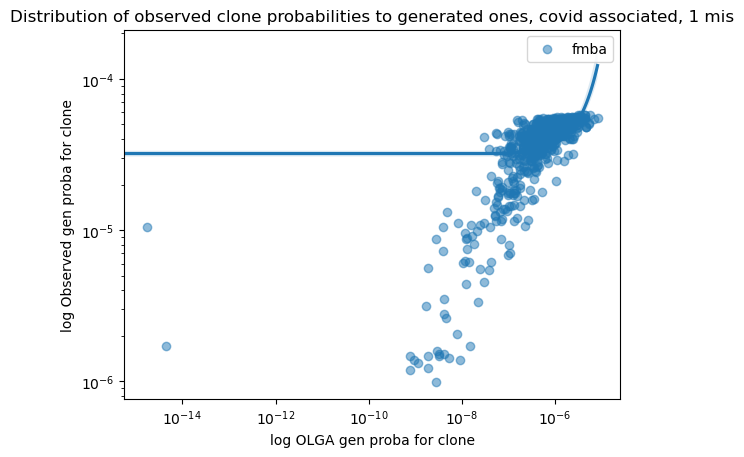

In [15]:
probas_beta = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRB_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv'], 
                                    desc='covid associated, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv', 
                                    labels=['fmba'])['fmba']

In [16]:
covid_clones_beta = clean_beta_cm.columns[1:]
res_beta = seqs2hamming(covid_clones_beta, viz_method='graphopt')

In [17]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASAPGGSYEQYF,0,-291.606139,177.859241,195,-121.096846,93.749900
1,CASIPGGSYEQYF,0,-277.931569,180.149147,195,-121.096846,93.749900
2,CASKPGGSYEQYF,0,-266.199973,173.381367,195,-121.096846,93.749900
3,CASLPGGSYEQYF,0,-281.048457,165.479545,195,-121.096846,93.749900
4,CASNPGGSYEQYF,0,-282.715342,193.295274,195,-121.096846,93.749900
...,...,...,...,...,...,...,...
562,CSAKSGHEQYF,55,571.287430,126.554056,3,561.433403,119.893115
563,CSASSGHEQYF,55,550.737483,125.189686,3,561.433403,119.893115
564,CSATSGHEQYF,55,562.275296,107.935603,3,561.433403,119.893115
565,CSASDRGYEQYF,56,362.820505,-492.558448,1,362.820505,-492.558448


In [18]:
beta_clusters_list = list(res_beta[['cluster', 'cluster_size']].drop_duplicates().sort_values(by='cluster_size', ascending=False).cluster)

In [19]:
beta_cluster_to_epi = read_association_data('figures/associations/fmba_TRB_sign_assoc.csv')

In [20]:
print(beta_cluster_to_epi)

{0:    Unnamed: 0 antigen.epitope antigen.species  count      pval  cluster  \
0          76       VTEHDTLLY             CMV     33  0.000050        0   
1          73      TTDPSFLGRY      SARS-CoV-2     47  0.000021        0   

   all_clust_count  enrichment_score  
0               38          0.868421  
1               79          0.594937  , 3:     Unnamed: 0   antigen.epitope antigen.species  count          pval  \
2           48          TVYGFCLL            MCMV      5  1.527050e-08   
3           41         SIIAYTMSL      SARS-CoV-2      5  3.626797e-07   
4           32         MLAKALRKV      SARS-CoV-2     17  1.527822e-05   
5           36  QARQMVQAMRTIGTHP      InfluenzaA     18  2.864609e-06   
6           39         RLRAEAQVK             EBV     19  3.582257e-04   
7           31         LTDEMIAQY      SARS-CoV-2     20  6.455402e-04   
8           37          RALEYKNL            MCMV     27  2.864609e-06   
9           42         SPRWYFYYL      SARS-CoV-2     28  5.692258

# α chain biomarkers postprocessing

In [21]:
clean_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

In [22]:
raw_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0'])

In [23]:
clean_alpha_cm

,run,CAAADFNKFYF,CAAADNFNKFYF,CAAAEYNFNKFYF,CAAAFNKFYF,CAAAKYNFNKFYF,CAAALYNFNKFYF,CAAANFNKFYF,CAAANNFNKFYF,CAAAPYNFNKFYF,...,CVVVYNFNKFYF,CVVYLYNFNKFYF,CVVYNFNKFYF,CVYNFNKFYF,CYNFNKFYF,LYNFNKFYF,SDNFNKFYF,SYNFNKFYF,WYNFNKFYF,YALSSGSARQLTF
0,050002290808_S117_L002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,250002590808_S99_L002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,330000390808_S24_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,500003530808_S38_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,460000160808_S8_L001,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,p17_22_DNA_S38_L001,3,2,0,2,2,2,7,1,1,...,0,0,2,1,0,0,1,1,1,0
1269,p17_43_DNA_S58_L001,1,2,1,0,3,4,2,2,1,...,3,2,4,2,2,2,0,2,2,0
1270,p17_49-2_DNA_S14_L001,2,3,4,1,0,2,4,2,3,...,4,2,13,8,2,2,0,2,2,2
1271,p17_77-1_DNA_S4_L001,0,0,0,0,0,2,2,0,0,...,0,0,1,1,0,0,0,0,0,1


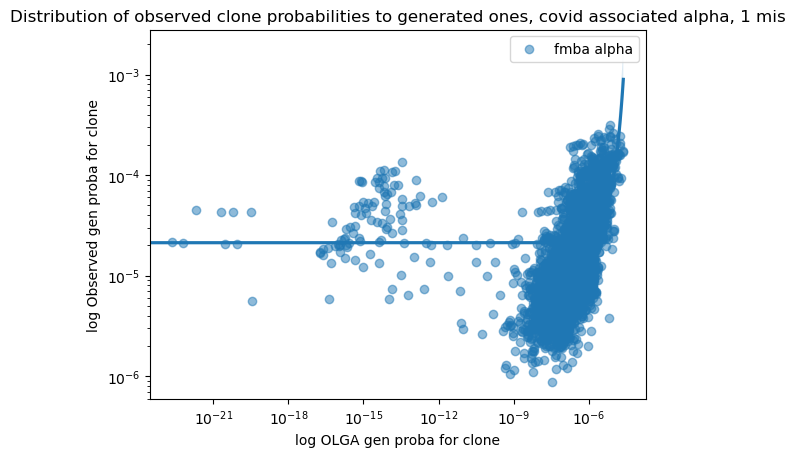

In [24]:
probas_alpha = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRA_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv'], 
                                    desc='covid associated alpha, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv', 
                                    labels=['fmba alpha'],
                                    make_bool_features=False)['fmba alpha']

In [25]:
covid_clones_alpha = clean_alpha_cm.columns[1:]
res_alpha = seqs2hamming(covid_clones_alpha, viz_method='drl')

In [26]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADFNKFYF,0,-164.356018,63.686111,455,-150.112137,111.718690
1,CAAANFNKFYF,0,-106.604126,138.446899,455,-150.112137,111.718690
2,CAADDFNKFYF,0,-164.240143,64.540131,455,-150.112137,111.718690
3,CAAGDFNKFYF,0,-165.967865,64.249954,455,-150.112137,111.718690
4,CAAHDFNKFYF,0,-164.662354,63.386375,455,-150.112137,111.718690
...,...,...,...,...,...,...,...
4388,CVVSDLMEYGNKLVF,111,34.082340,-305.157593,2,34.198614,-305.395142
4389,CVVSDRMEYGNKLVF,111,34.314888,-305.632690,2,34.198614,-305.395142
4390,CVVSEPSGGYQKVTF,112,-345.421539,-15.734495,1,-345.421539,-15.734495
4391,CVVSGYGAAGNKLTF,113,-252.051468,-235.314926,1,-252.051468,-235.314926


In [27]:
alpha_clusters_list = list(res_alpha[['cluster', 'cluster_size']].drop_duplicates().sort_values(by='cluster_size', ascending=False).cluster)

In [28]:
alpha_cluster_to_epi = read_association_data('figures/associations/fmba_TRA_sign_assoc_with_max_enrichment.csv')

# α, β co-occorence analysis

In [29]:
cooccurence_df = pd.read_csv('data/TRA_TRB_cooccurence_matrix_cooccurence_85.csv').T
annot_df = pd.read_csv('data/alpha_beta_paired_epitopes.csv').T
corr_df = pd.read_csv('data/cluster_correlations.csv').T

In [30]:
all_alpha_cm = pd.read_csv('data/clone_matrix_fmba_TRA_top_500k.csv', nrows=200000)
all_alpha_cm = prepare_clonotype_matrix(clonotype_matrix=all_alpha_cm).merge(clean_alpha_cm)
fold_change_data_alpha = get_top_changed_clonotypes(clonotype_matrix=all_alpha_cm.merge(prepare_run_column(desc_alpha[~desc_alpha.folder.str.contains('NovaSeq6')][['run']])), 
                           desc=desc_alpha, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'),
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_alpha

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,AAAGNKLTF,0.986422,0.002430,0.004954,2.038189,1.027288
1,AAGGTSYGKLTF,0.996953,0.017989,0.045346,2.520827,1.333897
2,AAGNKLTF,0.781200,0.000747,0.001818,2.435800,1.284396
3,AAGNMLTF,0.988131,0.002821,0.006232,2.209055,1.143429
4,AAGNNRKLIW,0.083952,0.000873,0.003516,4.026632,2.009574
...,...,...,...,...,...,...
203634,LYNFNKFYF,0.000001,0.000550,0.003075,5.595383,2.484237
203635,SDNFNKFYF,0.000012,0.000146,0.001535,10.516751,3.394617
203636,SYNFNKFYF,0.000015,0.000667,0.003159,4.735527,2.243525
203637,WYNFNKFYF,0.000021,0.000631,0.003023,4.788363,2.259533


In [31]:
all_beta_cm = pd.read_csv('data/clone_matrix_fmba_TRB_top_500k.csv', nrows=200000)
all_beta_cm = prepare_clonotype_matrix(clonotype_matrix=all_beta_cm).merge(clean_beta_cm)
fold_change_data_beta = get_top_changed_clonotypes(clonotype_matrix=all_beta_cm.merge(prepare_run_column(desc_beta[~desc_beta.folder.str.contains('NovaSeq6')][['run']])), 
                           desc=desc_beta, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'),
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_beta

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CAAAAGSSYNEQFF,5.014465e-02,0.000000,0.000199,inf,inf
1,CAAADYGYTF,1.277567e-01,0.000160,0.000539,3.377711,1.756046
2,CAAAGANVLTF,8.774517e-02,0.000129,0.000833,6.470137,2.693796
3,CAAAGDGNTIYF,5.034804e-01,0.000040,0.000071,1.751708,0.808762
4,CAAAGGDTQYF,7.949872e-01,0.000182,0.000306,1.680820,0.749165
...,...,...,...,...,...,...
200518,CSASDRGYEQYF,4.001764e-08,0.000832,0.004896,5.882036,2.556316
200519,CSASGGGYEQYF,1.233402e-06,0.001255,0.007295,5.811297,2.538860
200520,CSASSGHEQYF,4.493351e-08,0.000730,0.004018,5.502004,2.459957
200521,CSASSSYEQYF,1.910973e-07,0.001494,0.007728,5.171681,2.370633


In [32]:
fold_change_data_beta = fold_change_data_beta.replace({np.inf: 2}).dropna()
fold_change_data_alpha = fold_change_data_alpha.replace({np.inf: 2}).dropna()

# plotting fig2

In [33]:
def plot_logo(clones, ax):
    logomaker.Logo(logomaker.alignment_to_matrix(list(clones)), color_scheme='skylign_protein', ax=ax)

In [34]:
desc_beta = prepare_run_column(desc_beta)
desc_alpha = prepare_run_column(desc_alpha)

(array([1977., 2275., 1282.,  441.,  256.,  161.,   70.,   54.,   45.,
         109.]),
 array([0.01212121, 0.11090909, 0.20969697, 0.30848485, 0.40727273,
        0.50606061, 0.60484848, 0.70363636, 0.80242424, 0.90121212,
        1.        ]),
 <BarContainer object of 10 artists>)

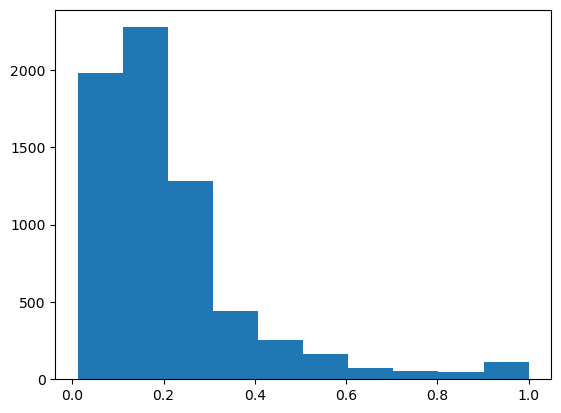

In [35]:
plt.hist(cooccurence_df.to_numpy().flatten())

In [36]:
alpha_cluster_to_size = {x: y for x, y in zip(res_alpha.cluster, res_alpha.cluster_size)}

In [37]:
beta_cluster_to_size = {x: y for x, y in zip(res_beta.cluster, res_beta.cluster_size)}

In [38]:
import math

In [39]:
size_df = pd.DataFrame(data=np.array([[math.sqrt(alpha_cluster_to_size[a]*beta_cluster_to_size[b]) for a in range(res_alpha.cluster.max() + 1)] for b in
                                  range(res_beta.cluster.max() + 1)]))

In [40]:
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib as mpl

def plot_cooccurence_heatmap_with_epitopes_labeling_bubble(plotting_df, annot_df, epi_df, fig=None, ax=None,
                                                           epitopes_count_threshold=0, corr_threshold_row=0.1,
                                                           corr_threshold_col=0.1, legend_x=1.05):
    if ax is None:
        if plotting_df.shape[0] > plotting_df.shape[1]:
            fig, ax = plt.subplots(figsize=(2.5, 20))
        else:
            fig, ax = plt.subplots(figsize=(20, 2.5))

    selected_cols = plotting_df.loc[:, plotting_df.max() > corr_threshold_col].columns
    
    data_to_plot = plotting_df.loc[plotting_df.max(axis=1) > corr_threshold_row, selected_cols]
    bubble_sizes = annot_df.loc[list(plotting_df.max(axis=1) > corr_threshold_row), selected_cols]
    epi_df = epi_df.loc[list(plotting_df.max(axis=1) > corr_threshold_row), selected_cols]
    
    ylabels = np.array([x for x in data_to_plot.index])
    xlabels = np.array([x for x in data_to_plot.columns])

    N = len(ylabels)
    M = len(xlabels)
    x, y = np.meshgrid(np.arange(M), np.arange(N))
    s = np.array(bubble_sizes) + 100
    c = np.array(data_to_plot)
    plt.set_cmap('coolwarm')
    R = s / s.max() / 2
    circles = [plt.Circle((j, i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    # recs = [plt.Circle((j, i), radius=0.5 if r > 0 else 0, facecolor=(0.5, 0.5, 0.5, 0.5)) for r, j, i in zip(np.array(epi_df).flat, x.flat, y.flat)]
    lines = [mpl.lines.Line2D([j-0.5, j-0.5, j+0.5, 0.5+j], [i+0.5, i-0.5, i-0.5, i+0.5], linestyle='--') for r, j, i in zip(np.array(epi_df).flat, x.flat, y.flat) if r!= 0 ]
    col = PatchCollection(circles, array=c.flatten(), cmap="coolwarm")
    
    plot = ax.add_collection(col)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='1%', pad=1)
    cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
    # cbar.set_label('fraction of α-β co-occured pairs')
    cax.xaxis.set_ticks_position('top')
    cax.xaxis.set_label_position('top')
    cax.set_xlabel('fraction of α-β co-occured pairs')
    
    plot = ax.add_collection(PatchCollection(lines, alpha=0.3, facecolors=("green", ), edgecolors=("green",)))
    
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
    ax.grid(which='minor')

    ax.set_ylabel('α cluster index')
    ax.set_xlabel('β cluster index')
    ax.tick_params(labelrotation=30)

In [41]:
cooccurence_df.reset_index(inplace=True, drop=True)
cooccurence_df.shape

(58, 115)

In [42]:
annot_df.reset_index(inplace=True, drop=True)
annot_df.shape

(58, 115)

In [43]:
corr_df.reset_index(inplace=True, drop=True)
corr_df.shape

(58, 115)

updated version
0.037144354572518475 172.5880831650096 0.7289690797910839 1.2336384805210282e-12 0.00426137094663467
0.05745678130328694 139.78275631852478 0.6500970065803043 1.189023363896838e-10 0.007703443437808521
TTDPSFLGRY
SIIAYTMSL
MLAKALRKV
QARQMVQAMRTIGTHP
RLRAEAQVK
LTDEMIAQY
RALEYKNL
SPRWYFYYL
SSLENFRAYV
NLVPMVATV
TMADLVYAL
NLVPMVATV
LLQTGIHVRVSQPSL
updated version
0.05090985529133383 -70.28841181472444 0.8446141611400956 4.015583697323389e-20 0.003913339576709351
0.06453824299562941 -40.73002824548598 0.8462769924469568 4.93464307304288e-23 0.004600183626121365
LMIERFVSL
MFLARGIVF
YINVFAFPF
DPFRLLQNSQVFS
APFSEQEQPVLG
HWFVTQRNFYEPQII
RISNCVADYSVLYNS
ALNTLVKQL
YVYSRVKNL
NVILLNKHI
MLDLQPETT
YTVSCLPFT
RTLNAWVKV
LLLEWLAMA
NLSDRVVFV
NLSDRVVFV
KLGGALQAK
NQKLIANQF
KLGGALQAK
SLFNTVATLY
KLGGALQAK
LPEGLPQGQLTAY
LPEPLGQGQLTAY
LPEPLPQAQLTAY
LPEPLPQGGLTAY
LPEPLPQGQGTAY
LPEPLPQGQLGAY
LPEPLPQGQLTAY
LPEPLPQGQLTGY
RLQSLQTYV
TTDPSFLGRY
YLQPRTFLL
QLQPFPQPELPY
NLVPMVATV
RLNQLESKV
NLSDRVVFV
PTDNY

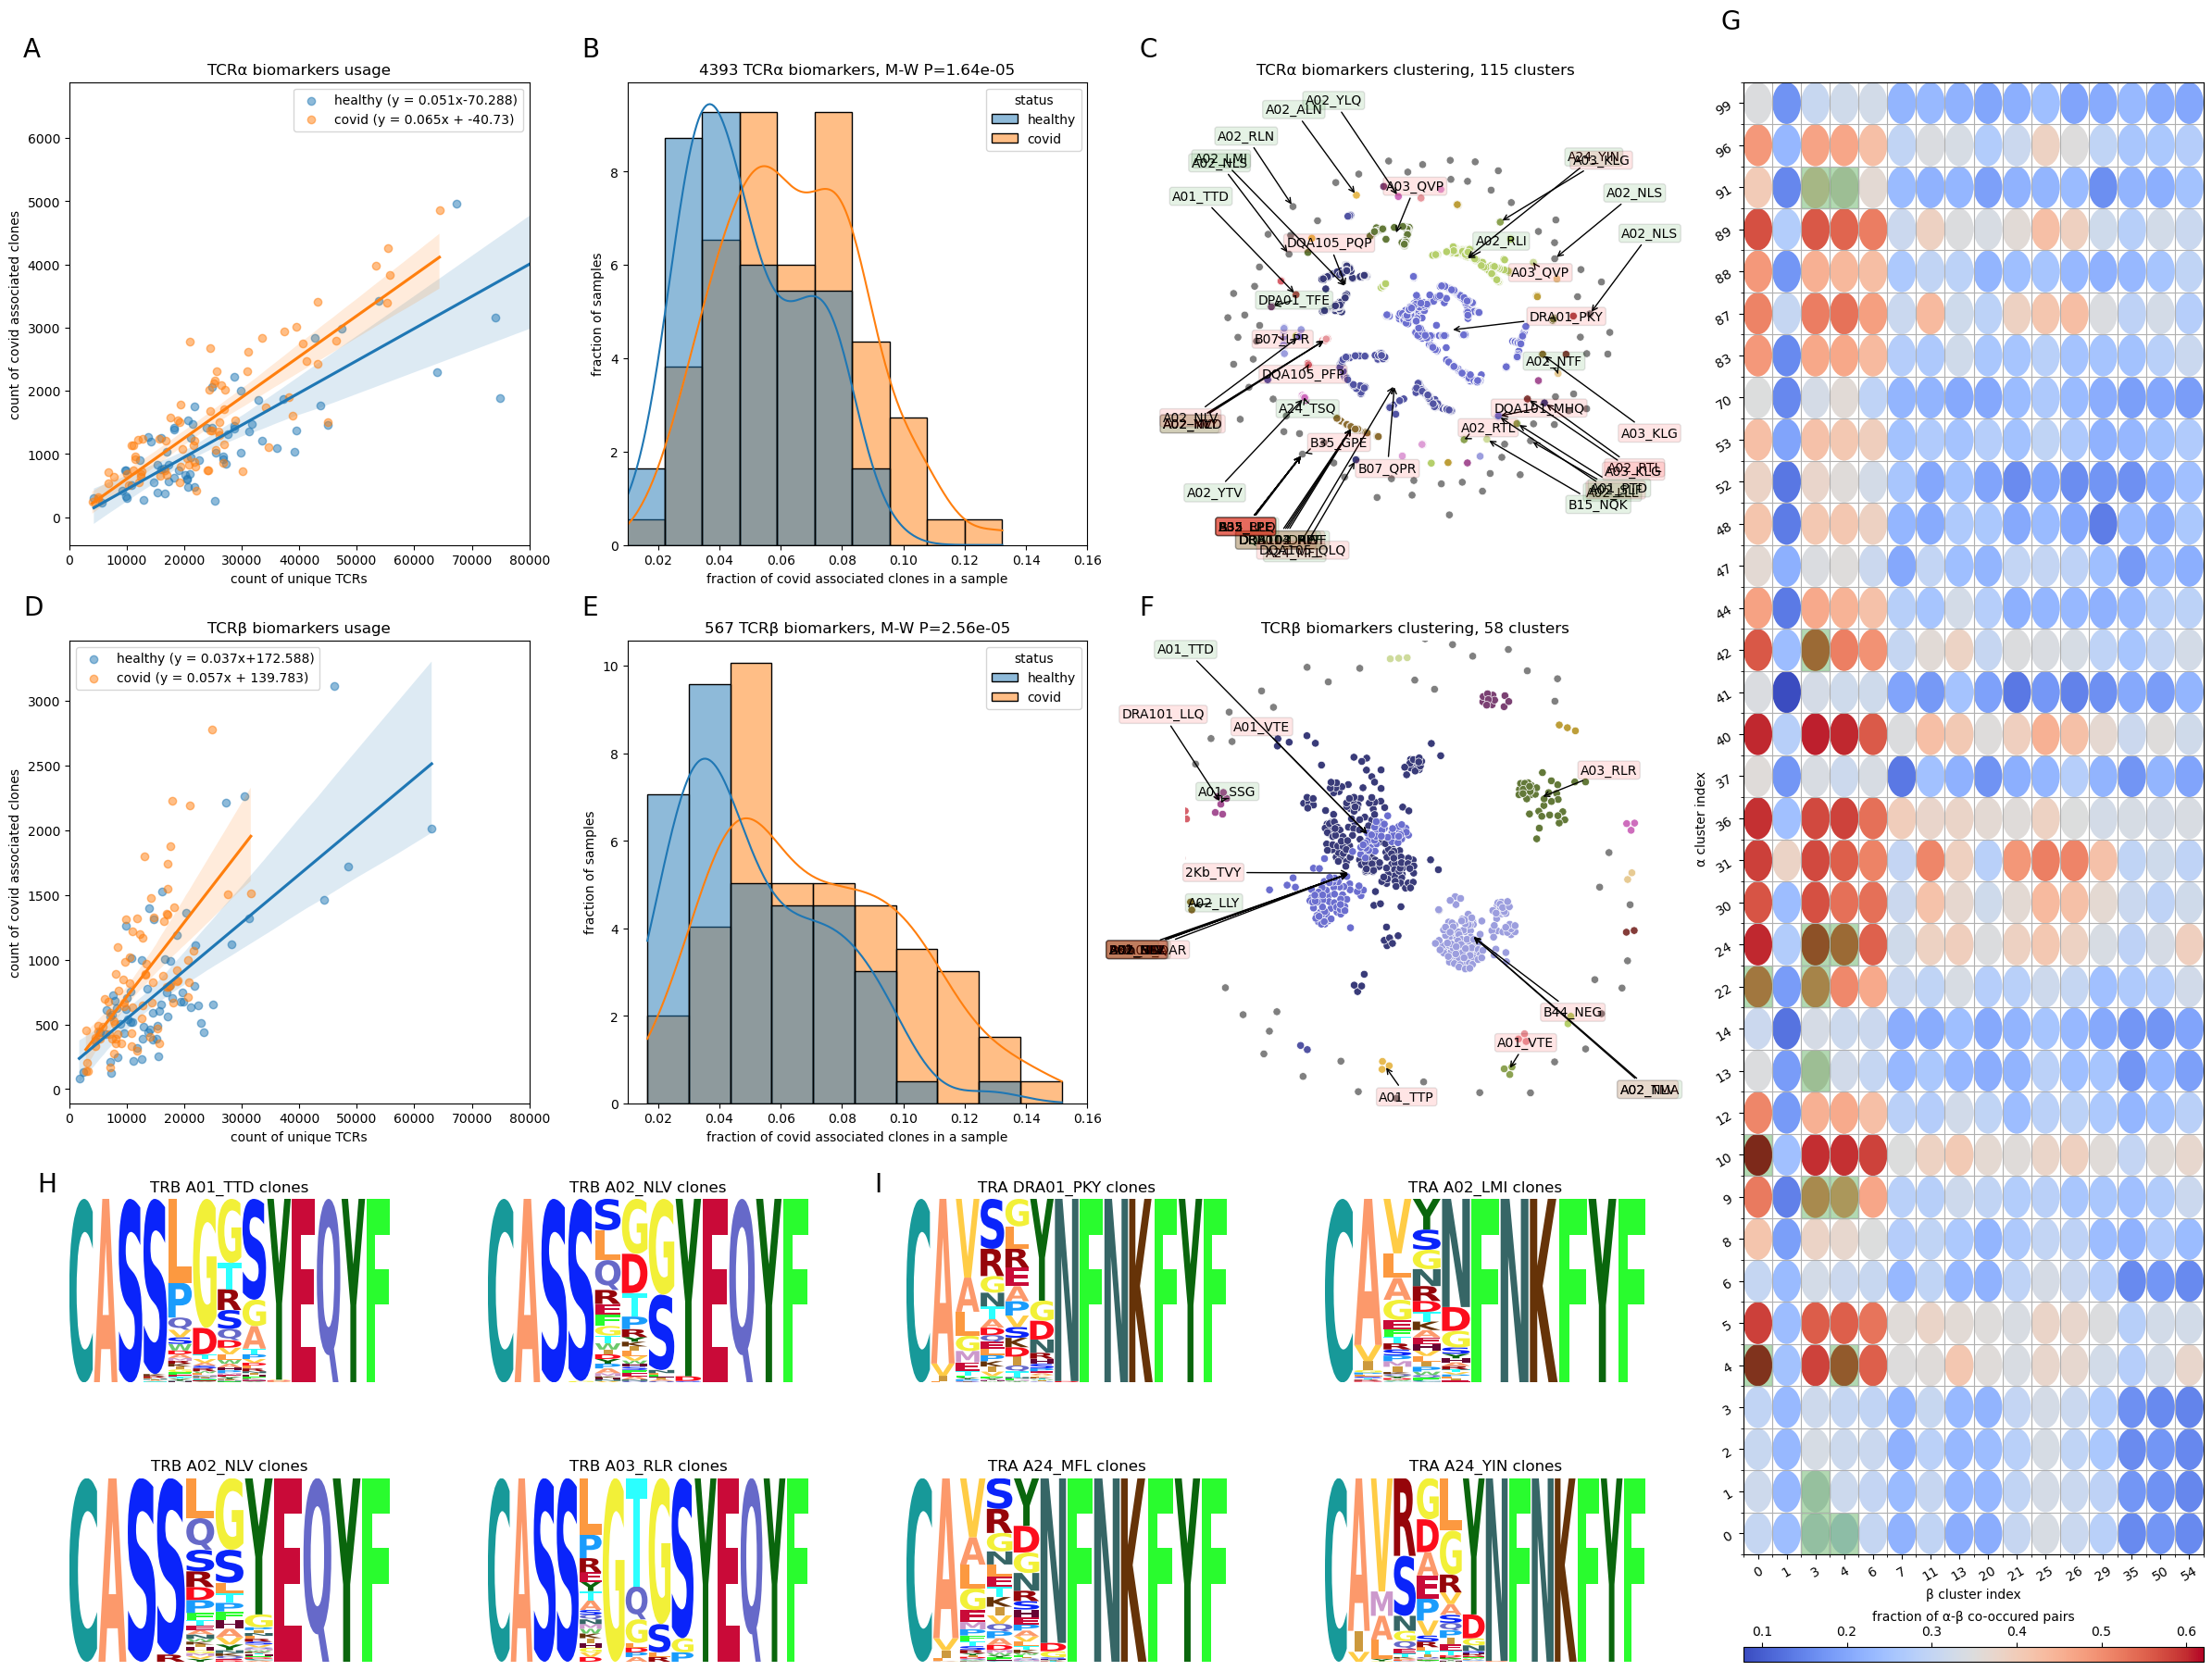

In [44]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
time = np.linspace(0, 10, 1000)
height = np.sin(time)
weight = time*0.3 + 2
score = time**2 + height
distribution = np.random.normal(0, 1, len(time))
fig = plt.figure(figsize=(24, 18))
gs = GridSpec(nrows=12, 
              ncols=16)
font_size=20
delta_x=-0.1
delta_y=1.1

ax2 = fig.add_subplot(gs[:4, :4])
ax3 = fig.add_subplot(gs[:4, 4:8])
ax6 = fig.add_subplot(gs[:4, 8:12])
ax0 = fig.add_subplot(gs[4:8, :4])
ax1 = fig.add_subplot(gs[4:8, 4:8])
ax5 = fig.add_subplot(gs[4:8, 8:12])
significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_beta_cm[clean_beta_cm.run.isin(test_runs_beta)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc_beta, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

ax1.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_xlim(0.01, 0.16)
ax0.set_xlim(0, 80000)


beta_cluster_to_epi_abbr = plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', dist_to_center=500, global_zero_based=True, ax=ax5)
ax5.set_xlim(-600, 600)
ax5.set_ylim(-600, 600)
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.legend().remove()
ax5.set_title(f'TCRβ biomarkers clustering, {res_beta.cluster.max() + 1} clusters')

####################################################

significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_alpha_cm[clean_alpha_cm.run.isin(test_runs_alpha)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc_alpha, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title(f'TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

ax3.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
ax3.set_xlim(0.01, 0.16)
ax2.set_xlim(0, 80000)


alpha_cluster_to_epi_abbr = plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=250, 
                                                center_diff_threshold=75,
                                                ax=ax6)
ax6.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.axis('off')
ax6.set_xlim(-500, 500)
ax6.set_ylim(-500, 600)
ax6.legend().remove()
ax6.set_title(f'TCRα biomarkers clustering, {res_alpha.cluster.max() + 1} clusters')
###################################################

ax7 = fig.add_subplot(gs[:, 12:])
plot_cooccurence_heatmap_with_epitopes_labeling_bubble(corr_df.T, cooccurence_df.T, annot_df.T, fig=fig, ax=ax7, 
       corr_threshold_row=np.quantile(corr_df.to_numpy().flatten(), 0.97), 
       corr_threshold_col=np.quantile(corr_df.to_numpy().flatten(), 0.97), 
       epitopes_count_threshold=0,  legend_x=1.11)
ax7.text(delta_x+0.05, delta_y-0.05, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################

i, j = 0, 0 
while i < 4:
    if beta_clusters_list[j] in beta_cluster_to_epi_abbr:
        cluster_idx = beta_clusters_list[j]
        i += 1
        ax = fig.add_subplot(gs[8+2*(j % 2): 10+2*(j%2), j//2 * 3 : j//2 * 3 + 3])
        epi = beta_cluster_to_epi_abbr[cluster_idx]
        plot_logo(res_beta[res_beta.cluster == cluster_idx].cdr3, ax)
        ax.set_title(f'TRB {epi} clones')
        ax.axis('off')
        if i == 1:
            ax.text(delta_x, delta_y+0.05, 'H',
                     horizontalalignment='left',
                     verticalalignment='top',
                     transform=ax.transAxes,
                     size=font_size)
    j += 1

###################################################

i, j = 0, 0 
while i < 4:
    if alpha_clusters_list[j] in alpha_cluster_to_epi_abbr:
        cluster_idx = alpha_clusters_list[j]
        ax = fig.add_subplot(gs[8+2*(i % 2): 10+2*(i%2), i//2 * 3 + 6: i//2 * 3 + 9])
        i += 1
        epi = alpha_cluster_to_epi_abbr[cluster_idx]
        plot_logo(res_alpha[res_alpha.cluster == cluster_idx].cdr3, ax)
        ax.set_title(f'TRA {epi} clones')
        ax.axis('off')
        if i == 1:
            ax.text(delta_x, delta_y+0.05, 'I',
                     horizontalalignment='left',
                     verticalalignment='top',
                     transform=ax.transAxes,
                     size=font_size)
    j += 1

###################################################
plt.tight_layout()
plt.savefig("figures/fig2.svg")
plt.savefig("figures/fig2.pdf")
plt.savefig("figures/fig2.png")
plt.show()

### Figure 2. FMBA data TCRα and TCRβ biomarkers analysis.

A, D. Scatterplots comparing the distribution of the number of COVID-associated TCRβs/TCRαs to the total number of unique TCRβs/TCRαs sampled for COVID-19 patients and healthy donors.

B, E. Distribution of the number of COVID-associated TCRβs/TCRαs showing the significant difference in COVID-19 patients/ healthy donors.

C, F. Vizualization of COVID-associated TCRβs/TCRαs based on hamming distance. The closer the points are the less the hamming distance between the CDRs is.

G. Coouccurence of CDRs in α/β clusters. Coouccurence was calculated as the percent of TCRα/TCRβ pairs which are found together in more than 80% of samples which contain either the described TCRα, or TCRβ biomarker. The number in each cell of the matrix corresponds to the number of epitopes from VDJdb, which are found to be associated with both TCRα and TCRβ clusters.

# plotting supp fig 1

In [53]:
df = fold_change_data_alpha[(fold_change_data_alpha['log_fold_change'] != np.inf) & (fold_change_data_alpha['log_fold_change'] > 1)]
df['logp'] = np.log10(df.pval)

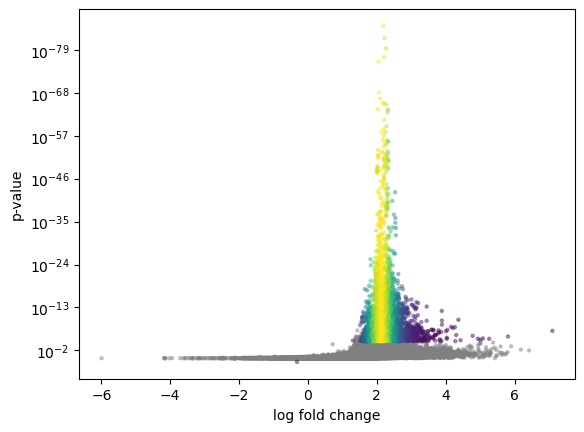

In [54]:
plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns)

In [52]:
raw_beta_cm = prepare_run_column(raw_beta_cm)
raw_alpha_cm = prepare_run_column(raw_alpha_cm)

updated version
0.03312300940510385 249.99256849498386 0.6676528704636189 4.151152860932546e-41 0.0021113836195052155
0.04635590016166473 233.71095212756848 0.783127012049782 1.3238046058997084e-160 0.0013282691185498095
updated version
0.08438784363662113 134.94635112845663 0.5726068671160857 1.1552427617734683e-28 0.006851205538826883
0.13469682587991438 -42.52127087467761 0.906992359029593 1.0786585894097744e-305 0.00220029972263664


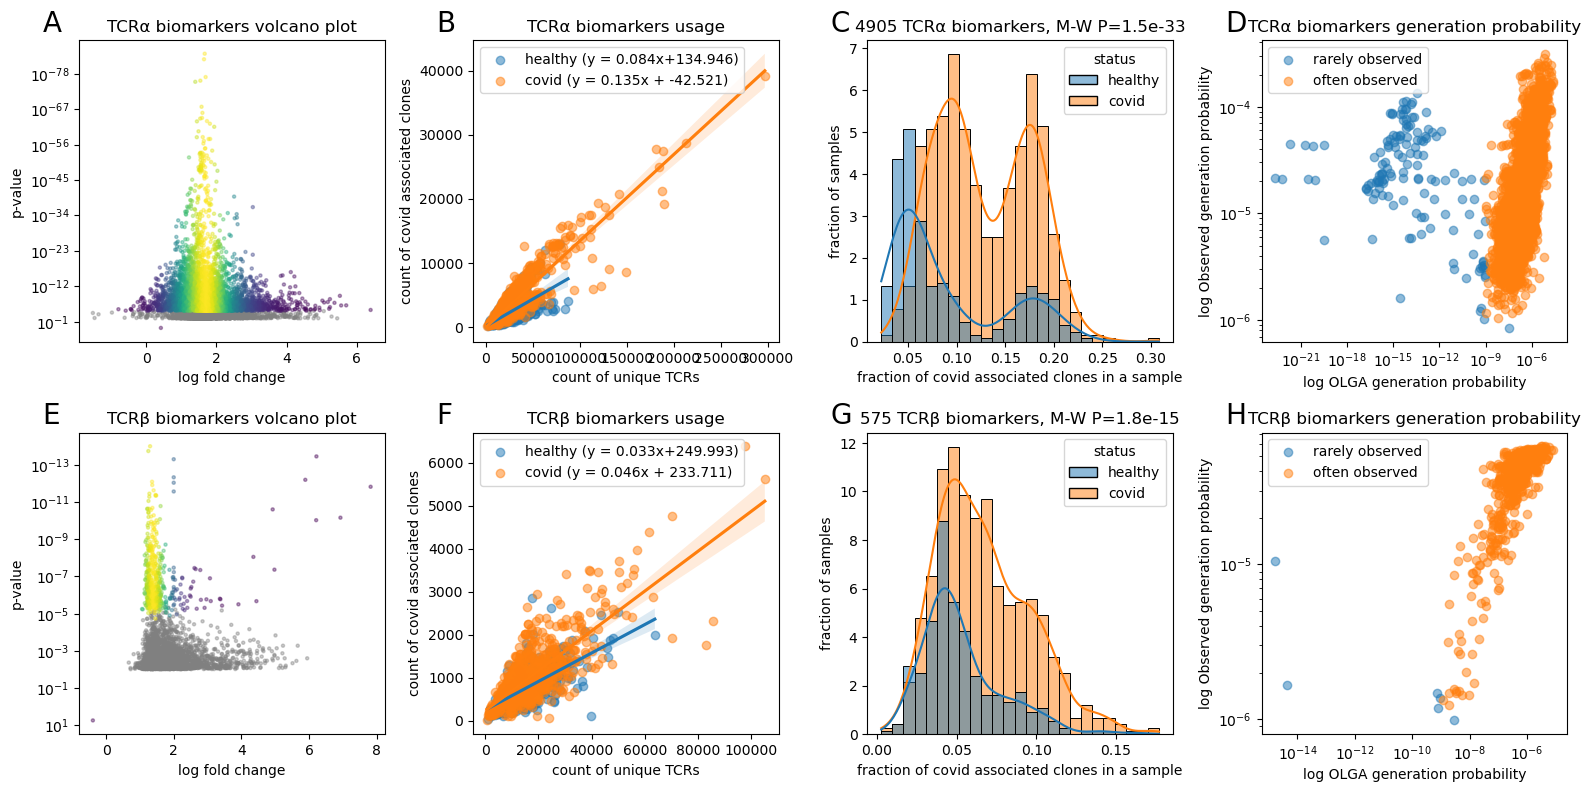

In [49]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(16, 8))
gs = GridSpec(nrows=2, 
              ncols=4)
font_size=20
delta_x=-0.12
delta_y=1.1

ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[0, 3])
ax0 = fig.add_subplot(gs[1, 1])
ax1 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[1, 3])
significant_clones_distribution(significant_clonotype_matrix=raw_beta_cm[raw_beta_cm.run.isin(train_runs_beta)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc_beta, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

plot_olga_cleanup_data(probas_beta, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax4)
ax4.set_title('TCRβ biomarkers generation probability')
ax4.legend()
ax4.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

####################################################


significant_clones_distribution(significant_clonotype_matrix=raw_alpha_cm[raw_alpha_cm.run.isin(train_runs_alpha)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc_alpha, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title('TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)


plot_olga_cleanup_data(probas_alpha, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax5)
ax5.set_title('TCRα biomarkers generation probability')
ax5.legend()
ax5.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

###################################################
ax6 = fig.add_subplot(gs[0, 0])

plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns, ax=ax6, pval_plotting_threshold=0.01)
ax6.set_title('TCRα biomarkers volcano plot')
ax6.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

###################################################
ax7 = fig.add_subplot(gs[1, 0])

plot_volcano(fold_change_data_beta, selected_clones=clean_beta_cm.columns, ax=ax7, pval_plotting_threshold=0.01)
ax7.set_title('TCRβ biomarkers volcano plot')
ax7.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################

plt.tight_layout()
plt.savefig("figures/supp_fig1.svg")
plt.savefig("figures/supp_fig1.pdf")
plt.savefig("figures/supp_fig1.png")
plt.show()

In [47]:
def get_avg_percentage(significant_clonotype_matrix, run_to_number_of_clones, desc, by='covid'):
    for df in [significant_clonotype_matrix, run_to_number_of_clones, desc]:
        prepare_run_column(df)
    sign_clone_count = significant_clonotype_matrix.shape[1] - 1
    significant_clonotype_matrix['sum'] = significant_clonotype_matrix.sum(axis=1)

    significant_clonotype_matrix = significant_clonotype_matrix.merge(run_to_number_of_clones)
    
    ill_percents = pd.DataFrame(data={'percent': significant_clonotype_matrix['sum'] / significant_clonotype_matrix['number_of_clones']})
    return ill_percents

In [55]:
get_avg_percentage(raw_beta_cm.merge(desc_beta[desc_beta.covid == 'covid'][['run']]), 
                   pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'),
                   desc_beta).mean()

percent    0.067869
dtype: float64

In [56]:
get_avg_percentage(raw_alpha_cm.merge(desc_alpha[desc_alpha.covid == 'covid'][['run']]), 
                   pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'),
                   desc_alpha).mean()

percent    0.240702
dtype: float64

# Making up summary table for selected clones

In [65]:
vdjdb

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2,sort,sanger,no,no
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2,sort,sanger,no,no
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2,sort,sanger,no,no
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2,sort,sanger,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92766,30592,TRB,CASSPGQGGDNEQFF,TRBV7-3*01,TRBJ2-1*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSPGQGGDNEQFF"", ""cdr3_old"": ""CASSP...",0,sort,singlecell,no,no
92767,30593,TRA,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAPQGATNKLIF"", ""cdr3_old"": ""CAPQGATN...",2,sort,singlecell,no,no
92768,30593,TRB,CASSLGAGGQETQYF,TRBV5-1*01,TRBJ2-5*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSLGAGGQETQYF"", ""cdr3_old"": ""CASSL...",2,sort,singlecell,no,no
92769,30594,TRA,CLVGGSGGYNKLIF,TRAV4*01,TRAJ4*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQQPFPQPEQPFP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CLVGGSGGYNKLIF"", ""cdr3_old"": ""CLVGGS...",0,sort,singlecell,no,no


In [80]:
beta_cluster_to_epi[0]['count']

0    33
1    47
Name: count, dtype: int64

In [83]:
def get_most_frequent_cluster_by_vdjdb_occurence(vdjdb, cluster_epitopes, gene):
    cluster_epitopes['cluster_epitopes_freq'] = cluster_epitopes.apply(lambda x: x['count'] / vdjdb[
        (vdjdb.gene == gene) & (vdjdb['antigen.epitope'] == x['antigen.epitope'])].cdr3.nunique(), axis=1)
    cluster_epitopes = cluster_epitopes.merge(vdjdb[['antigen.epitope', 'mhc.a']])
    return cluster_epitopes.sort_values(by='cluster_epitopes_freq', ascending=False).reset_index(drop=True).loc[0, :]

def get_most_probable_antigen(x, cluster_to_epi, gene):
    if cluster_to_epi[x] is None or len(cluster_to_epi[x]) == 0:
        return '-', '-', 0, '-'
    df = cluster_to_epi[x]
    df = df[~df['antigen.species'].str.contains('apiens')]
    if len(df) == 0:
        return '-', '-', 0, '-'
    res = get_most_frequent_cluster_by_vdjdb_occurence(
        vdjdb, 
        df,
        gene=gene)
    return res[['antigen.epitope', 'antigen.species', 'count', 'mhc.a']]


def create_summary_stats_table(clustering_res, cluster_to_epi, cm, vdjdb, desc, gene='TRB'):
    df_cluster_to_epi = []
    for x, y in cluster_to_epi.items():
        df_cluster_to_epi.append(y)
        df_cluster_to_epi[-1]['cluster'] = x
    df_cluster_to_epi = pd.concat(df_cluster_to_epi)
    summary = clustering_res[['cluster', 'cluster_size']].drop_duplicates()
    summary = summary.merge(df_cluster_to_epi, how='left').fillna('-').rename(columns={'count': 'num_epi_associated_clones'})
    summary['num_epi_associated_clones'] = summary['num_epi_associated_clones'].replace({'-': 0}) 
    summary['mhc_a'] = summary['antigen.epitope'].apply(lambda x: list(vdjdb[vdjdb['antigen.epitope'] == x]['mhc.a'])[0].split(':')[0] if x != '-' else '-')
    summary['mhc_b'] = summary['antigen.epitope'].apply(lambda x: list(vdjdb[vdjdb['antigen.epitope'] == x]['mhc.b'])[0].split(':')[0] if x != '-' else '-')
    summary['fraction_epi_associated_clones'] = summary['num_epi_associated_clones'].astype(int) / summary['cluster_size'].astype(int)

    train_runs = desc[~desc.is_test_run].run
    test_runs = desc[desc.is_test_run].run

    healthy_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    healthy_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    covid_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])
    covid_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])

    train_cm = cm[cm.run.isin(train_runs)]
    test_cm = cm[cm.run.isin(test_runs)]
    summary['num_samples_with_cluster_train'] = summary.cluster.apply(
        lambda x: (train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_healthy'] = summary.cluster.apply(
        lambda x: (healthy_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_covid'] = summary.cluster.apply(
        lambda x: (covid_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())

    summary['num_samples_with_cluster_test'] = summary.cluster.apply(
        lambda x: (test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_healthy'] = summary.cluster.apply(
        lambda x: (healthy_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_covid'] = summary.cluster.apply(
        lambda x: (covid_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    
    summary['fraction_samples_with_cluster_train'] = summary['num_samples_with_cluster_train'] / len(train_cm)
    summary['fraction_of_healthy_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_healthy'] / summary['num_samples_with_cluster_train']
    summary['fraction_of_covid_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_covid'] / summary['num_samples_with_cluster_train']
    
    summary['fraction_samples_with_cluster_test'] = summary['num_samples_with_cluster_test'] / len(test_cm)
    summary['fraction_of_healthy_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_healthy'] / summary['num_samples_with_cluster_test']
    summary['fraction_of_covid_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_covid'] / summary['num_samples_with_cluster_test']
    
    # summary.to_excel(f'figures/clustering_summary_{gene}.xlsx')
    summary.to_csv(f'figures/clustering_summary_{gene}.csv', index=False)
    return summary

In [84]:
beta_summary = create_summary_stats_table(res_beta, beta_cluster_to_epi, clean_beta_cm, vdjdb, desc=desc_beta, gene='TRB')
beta_summary

,cluster,cluster_size,Unnamed: 0,antigen.epitope,antigen.species,num_epi_associated_clones,pval,all_clust_count,enrichment_score,mhc_a,...,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,195,76.0,VTEHDTLLY,CMV,33.0,0.00005,38.0,0.868421,HLA-A*01,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
1,0,195,73.0,TTDPSFLGRY,SARS-CoV-2,47.0,0.000021,79.0,0.594937,HLA-A*01,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
2,1,1,-,-,-,0.0,-,-,-,-,...,457,70,33,37,0.558442,0.240864,0.759136,0.476190,0.471429,0.528571
3,2,2,-,-,-,0.0,-,-,-,-,...,173,19,7,12,0.193878,0.172249,0.827751,0.129252,0.368421,0.631579
4,3,117,48.0,TVYGFCLL,MCMV,5.0,0.0,5.0,1.0,H-2Kb,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,54,6,5.0,SSGDATTAY,SARS-CoV-2,1.0,0.000034,1.0,1.0,HLA-A*01,...,444,75,28,47,0.534323,0.229167,0.770833,0.510204,0.373333,0.626667
67,54,6,2.0,LLQTGIHVRVSQPSL,CMV,4.0,0.000022,20.0,0.2,HLA-DRA1*01,...,444,75,28,47,0.534323,0.229167,0.770833,0.510204,0.373333,0.626667
68,55,3,-,-,-,0.0,-,-,-,-,...,106,9,1,8,0.114100,0.138211,0.861789,0.061224,0.111111,0.888889
69,56,1,-,-,-,0.0,-,-,-,-,...,122,18,6,12,0.132653,0.146853,0.853147,0.122449,0.333333,0.666667


In [85]:
alpha_summary = create_summary_stats_table(res_alpha, alpha_cluster_to_epi, clean_alpha_cm, vdjdb, desc=desc_alpha, gene='TRA')
alpha_summary

,cluster,cluster_size,Unnamed: 0,antigen.epitope,antigen.species,num_epi_associated_clones,pval,all_clust_count,enrichment_score,mhc_a,...,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,455,13.0,PQPELPYPQPE,Wheat,13.0,0.001307,13.0,1.0,HLA-DQA1*05,...,419,13,6,7,0.462155,0.192678,0.807322,0.086667,0.461538,0.538462
1,0,455,9.0,LMIERFVSL,SARS-CoV-2,20.0,0.0,20.0,1.0,HLA-A*02,...,419,13,6,7,0.462155,0.192678,0.807322,0.086667,0.461538,0.538462
2,1,1014,15.0,QPRAPIRPI,EBV,6.0,0.0,6.0,1.0,HLA-B*07,...,413,16,6,10,0.452360,0.187008,0.812992,0.106667,0.375000,0.625000
3,1,1014,12.0,MFLARGIVF,SARS-CoV-2,29.0,0.0,29.0,1.0,HLA-A*24,...,413,16,6,10,0.452360,0.187008,0.812992,0.106667,0.375000,0.625000
4,2,1409,17.0,PKYVKQNTLKLAT,InfluenzaA,47.0,0.000552,78.0,0.602564,HLA-DRA*01,...,409,9,4,5,0.454141,0.198039,0.801961,0.060000,0.444444,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,110,9,1.0,PTDNYITTY,SARS-CoV-2,9.0,0.0,10.0,0.9,HLA-A*01,...,400,62,31,31,0.472841,0.246704,0.753296,0.413333,0.500000,0.500000
130,111,2,-,-,-,0.0,-,-,-,-,...,115,8,0,8,0.116652,0.122137,0.877863,0.053333,0.000000,1.000000
131,112,1,-,-,-,0.0,-,-,-,-,...,192,20,10,10,0.203028,0.157895,0.842105,0.133333,0.500000,0.500000
132,113,1,-,-,-,0.0,-,-,-,-,...,40,3,1,2,0.037400,0.047619,0.952381,0.020000,0.333333,0.666667


In [86]:
beta_summary[beta_summary['antigen.epitope'] != '-']

,cluster,cluster_size,Unnamed: 0,antigen.epitope,antigen.species,num_epi_associated_clones,pval,all_clust_count,enrichment_score,mhc_a,...,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,195,76.0,VTEHDTLLY,CMV,33.0,0.00005,38.0,0.868421,HLA-A*01,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
1,0,195,73.0,TTDPSFLGRY,SARS-CoV-2,47.0,0.000021,79.0,0.594937,HLA-A*01,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
4,3,117,48.0,TVYGFCLL,MCMV,5.0,0.0,5.0,1.0,H-2Kb,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
5,3,117,41.0,SIIAYTMSL,SARS-CoV-2,5.0,0.0,5.0,1.0,HLA-B*07,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
6,3,117,32.0,MLAKALRKV,SARS-CoV-2,17.0,0.000015,17.0,1.0,HLA-A*02,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
7,3,117,36.0,QARQMVQAMRTIGTHP,InfluenzaA,18.0,0.000003,46.0,0.391304,HLA-DRA*01,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
8,3,117,39.0,RLRAEAQVK,EBV,19.0,0.000358,33.0,0.575758,HLA-A*03,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
9,3,117,31.0,LTDEMIAQY,SARS-CoV-2,20.0,0.000646,24.0,0.833333,HLA-A*01,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
10,3,117,37.0,RALEYKNL,MCMV,27.0,0.000003,56.0,0.482143,H-2Kb,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612
11,3,117,42.0,SPRWYFYYL,SARS-CoV-2,28.0,0.000057,82.0,0.341463,HLA-B*07,...,770,147,69,78,1.000000,0.285714,0.714286,1.000000,0.469388,0.530612


In [87]:
alpha_summary[alpha_summary['antigen.epitope'] != '-']

,cluster,cluster_size,Unnamed: 0,antigen.epitope,antigen.species,num_epi_associated_clones,pval,all_clust_count,enrichment_score,mhc_a,...,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,455,13.0,PQPELPYPQPE,Wheat,13.0,0.001307,13.0,1.0,HLA-DQA1*05,...,419,13,6,7,0.462155,0.192678,0.807322,0.086667,0.461538,0.538462
1,0,455,9.0,LMIERFVSL,SARS-CoV-2,20.0,0.0,20.0,1.0,HLA-A*02,...,419,13,6,7,0.462155,0.192678,0.807322,0.086667,0.461538,0.538462
2,1,1014,15.0,QPRAPIRPI,EBV,6.0,0.0,6.0,1.0,HLA-B*07,...,413,16,6,10,0.452360,0.187008,0.812992,0.106667,0.375000,0.625000
3,1,1014,12.0,MFLARGIVF,SARS-CoV-2,29.0,0.0,29.0,1.0,HLA-A*24,...,413,16,6,10,0.452360,0.187008,0.812992,0.106667,0.375000,0.625000
4,2,1409,17.0,PKYVKQNTLKLAT,InfluenzaA,47.0,0.000552,78.0,0.602564,HLA-DRA*01,...,409,9,4,5,0.454141,0.198039,0.801961,0.060000,0.444444,0.555556
5,3,101,1.0,LPRWYFYYL,HCoV-HKU1,32.0,0.0,32.0,1.0,HLA-B*07,...,428,23,9,14,0.487979,0.218978,0.781022,0.153333,0.391304,0.608696
6,4,250,9.0,QVPLRPMTYK,HIV-1,12.0,0.0,15.0,0.8,HLA-A*03,...,802,150,70,80,0.991986,0.280072,0.719928,1.000000,0.466667,0.533333
7,5,38,8.0,RTLNAWVKV,HIV-1,7.0,0.0,9.0,0.777778,HLA-A*02,...,779,147,67,80,0.959929,0.277365,0.722635,0.980000,0.455782,0.544218
8,6,392,9.0,RLITGRLQSL,SARS-CoV-2,9.0,0.000006,9.0,1.0,HLA-A*02,...,385,8,2,6,0.422974,0.189474,0.810526,0.053333,0.250000,0.750000
9,6,392,13.0,YINVFAFPF,SARS-CoV-2,13.0,0.0,13.0,1.0,HLA-A*24,...,385,8,2,6,0.422974,0.189474,0.810526,0.053333,0.250000,0.750000
